In [56]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.10.0

Found existing installation: tensorflow 2.10.0
Uninstalling tensorflow-2.10.0:
  Successfully uninstalled tensorflow-2.10.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.10.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)


In [57]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [58]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: six, h5py, numpy, tensorflow-estimator, astunparse, keras-preprocessing, packaging, google-pasta, opt-einsum, setuptools, typing-extensions, protobuf, gast, tensorflow-io-gcs-filesystem, wrapt, absl-py, grpcio, flatbuffers, tensorboard, keras, termcolor, libclang
Required-by: kapre


# 各パス指定

In [59]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [60]:
NUM_CLASSES = 4

# 入力長

In [61]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [62]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [63]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [85]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.LSTM(16, time_major=False, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [86]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 16, 2)             0         
                                                                 
 dropout_16 (Dropout)        (None, 16, 2)             0         
                                                                 
 lstm_7 (LSTM)               (None, 16, 16)            1216      
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 10)                2570      
                                                                 
 dense_18 (Dense)            (None, 4)                

In [87]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [88]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [89]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
30/32 [===========================>..] - ETA: 0s - loss: 1.3844 - accuracy: 0.4057
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 3s 32ms/step - loss: 1.3842 - accuracy: 0.4053 - val_loss: 1.3783 - val_accuracy: 0.3829
Epoch 2/1000
29/32 [==========================>...] - ETA: 0s - loss: 1.3752 - accuracy: 0.4006
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 14ms/step - loss: 1.3749 - accuracy: 0.4051 - val_loss: 1.3638 - val_accuracy: 0.4970
Epoch 3/1000
29/32 [==========================>...] - ETA: 0s - loss: 1.3510 - accuracy: 0.5178
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 14ms/step - loss: 1.3497 - accuracy: 0.5171 - val_loss: 1.3191 - val_accuracy: 0.5521
Epoch 4/1000
31/32 [============================>.] - ETA: 0s - 

In [90]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [91]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.5907634e-01 1.3251816e-03 5.7662022e-04 3.9021906e-02]
0


# 混同行列

## 1. 非LSTM

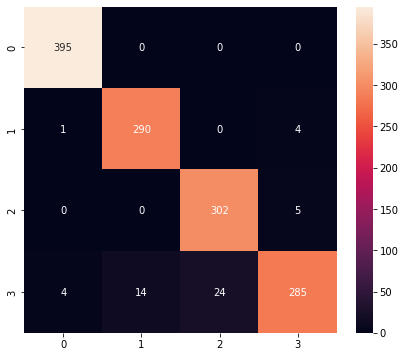

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.95      0.98      0.97       295
           2       0.93      0.98      0.95       307
           3       0.97      0.87      0.92       327

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## 2. LSTM

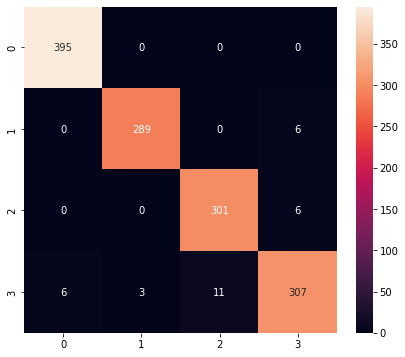

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.99      0.98      0.98       295
           2       0.96      0.98      0.97       307
           3       0.96      0.94      0.95       327

    accuracy                           0.98      1324
   macro avg       0.98      0.97      0.98      1324
weighted avg       0.98      0.98      0.98      1324



In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [93]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [100]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'
saved_model_path = 'saved_model'

In [95]:
tf.saved_model.save(model, saved_model_path)

In [96]:
# モデルを変換
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

15008

In [106]:
!pip install tf2onnx onnxsim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.8 MB/s 
     |████████████████████████████████| 235 kB 40.0 MB/s 
     |████████████████████████████████| 51 kB 5.8 MB/s 


# ONNXへの変換

In [107]:
!python -m tf2onnx.convert --opset 11 --saved-model saved_model --output point_history_classifier.onnx

2022-09-13 05:31:47.913032: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-13 05:31:50.053725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-13 05:31:50.053896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-13 05:31:50.053926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

In [108]:
!onnxsim point_history_classifier.onnx point_history_classifier.onnx
!onnxsim point_history_classifier.onnx point_history_classifier.onnx
!onnxsim point_history_classifier.onnx point_history_classifier.onnx

Installing onnxruntime by `/usr/bin/python3 -m pip install --user onnxruntime`, 
please wait for a moment..
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 7.5 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/onnxsim/onnx_simplifier.py", line 18, in <module>
    import onnxruntime as rt  # type: ignore
ModuleNotFoundError: No module named 'onnxruntime'

During handling of the above exception, another

# 推論テスト

In [97]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'input_1', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9579909  0.01342559 0.00907356 0.01950999]
0
